灵长类动物的视觉系统接受了大量的感官输入，这些感官输入远远超过了大脑能够完全处理的程度。然而，并非所有刺激的影响都是相等的。意识的聚集和专注使灵长类动物能够在复杂的视觉环境中将注意力引向感兴趣的物体，例如猎物和天敌。只关注一小部分信息的能力对进化更加有意义，使人类得以生存和成功。

自19世纪以来，科学家们一直致力于研究认知神经科学领域的注意力。本章的很多章节将涉及到这些研究：我们将首先回顾一个经典注意力框架，解释如何在视觉场景中展开注意力。受此框架中的**注意力提示**（attention cues）的启发，我们将设计能够利用这些注意力提示的模型。1964年的Nadaraya-Waston核回归（kernel regression）正是具有**注意力机制**（attention mechanism）的机器学习的简单演示。

然后，我们继续介绍的是注意力函数，它们在深度学习的注意力模型设计中被广泛使用。具体来说，我们将展示如何使用这些函数来设计**Bahdanau注意力**。Bahdanau注意力是深度学习中的具有突破性价值的注意力模型，它**双向对齐并且可以微分**。

最后，我们将描述仅仅基于注意力机制的**transformer**架构，该架构中使用了**多头注意力**（multi-head attention）和**自注意力**（self-attention）。自2017年横空出世，transformer一直都普遍存在于现代的深度学习应用中，例如语言、视觉、语音和强化学习领域。

# 10.1. 注意力提示
自经济学研究稀缺资源分配以来，我们正处在“注意力经济”时代， 即人类的注意力被视为可以交换的、有限的、有价值的且稀缺的商品。

注意力是稀缺的，而环境中的干扰注意力的信息却并不少。比如我们的视觉神经系统大约每秒收到$10^8$位的信息，这远远超过了大脑能够完全处理的水平。幸运的是，我们的祖先已经从经验（也称为数据）中认识到“并非感官的所有输入都是一样的”。在整个人类历史中，这种只将注意力引向感兴趣的一小部分信息的能力，使我们的大脑能够更明智地分配资源来生存、成长和社交，例如发现天敌、找寻食物和伴侣。

对长句子的翻译，人类通常是读一段翻译一段，而不是将整个句子输入再输出；对seq2seq模型来说，亦可学习这种翻译方式，即当翻译第一个词时，应该更关注第二个词、第三个词...而不是更关注句尾的一些词。量化这种行为就可用**注意力机制**。

## 10.1.1. 生物学中的注意力提示
注意力是如何应用于视觉世界中的呢？我们从当今十分普及的**双组件**（two-component）的框架开始讲起。在这个框架中，受试者基于**非自主性提示**和**自主性提示**有选择地引导注意力的焦点。
- 非自主性提示是基于环境中物体的突出性和易见性。
- 注意力在基于自主性提示去辅助选择时将更为谨慎。受试者的主观意愿推动，选择的力量也就更强大。

## 10.1.2. 查询（query）、键（key）和值（value）
自主性的与非自主性的注意力提示解释了人类的注意力的方式，下面我们看看如何通过这两种注意力提示，用神经网络来设计注意力机制的框架，

首先，考虑一个相对简单的状况，即只使用非自主性提示。要想将选择偏向于感官输入，我们可以简单地使用**参数化的全连接层**，甚至是**非参数化的最大汇聚层或平均汇聚层**。

因此，“是否包含自主性提示”将注意力机制与全连接层或汇聚层区别开来。

在注意力机制的背景下，我们将自主性提示称为**查询**（query）。给定任何查询，注意力机制通过**注意力汇聚**（attention pooling）将选择引导至**感官输入**（sensory inputs，例如中间特征表示）。在注意力机制中，这些感官输入被称为**值**（value）。更通俗的解释，每个值都与一个**键**（key）配对，这可以想象为感官输入的非自主提示。如图10.1.3所示，我们可以设计注意力汇聚，以便给定的查询（自主性提示）可以与键（非自主性提示）进行匹配，这将引导得出最匹配的值（感官输入）。

![](../img/10_8.png)

![](../img/10_1.png)


鉴于上面所提框架在图10.1.3中的主导地位，因此这个框架下的模型将成为本章的中心 然而，注意力机制的设计有许多替代方案。例如，我们可以设计一个不可微的注意力模型，该模型可以使用强化学习方法 [Mnih et al., 2014]进行训练。


## 10.1.3. 注意力的可视化
平均汇聚层可以被视为输入的加权平均值，其中各输入的权重是一样的。

实际上，注意力汇聚得到的是加权平均的总和值，其中权重是在给定的查询和不同的键之间计算得出的。

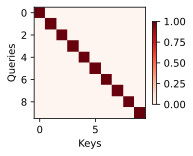

In [2]:
import torch
from d2l import torch as d2l

"""
为了可视化注意力权重，我们定义了show_heatmaps函数。 其输入matrices的形状是 （要显示的行数，要显示的列数，查询的数目，键的数目）。

在后面的章节中，我们将经常调用show_heatmaps函数来显示注意力权重。
"""

#@save
def show_heatmaps(matrices,xlabel,ylabel,titles=None,
                  figsize=(2.5,2.5),cmap='Reds'):
    """显示矩阵热图"""
    d2l.use_svg_display()

    num_rows,num_cols = matrices.shape[0],matrices.shape[1]

    fig,axes=d2l.plt.subplots(num_rows,
                              num_cols,
                              figsize=figsize,
                              sharex=True,
                              sharey=True,
                              squeeze=False)

    for i,(row_axes,row_matrices) in enumerate(zip(axes,matrices)):
        for j,(ax,matrix) in enumerate(zip(row_axes,row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(),cmap=cmap)
            if i==num_rows -1:
                ax.set_xlabel(xlabel)
            if j==0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm,ax=axes,shrink=0.6)


"""
下面我们使用一个简单的例子进行演示。 在本例子中，仅当查询和键相同时，注意力权重为1，否则为0。

- torch.eye:生成对角线全为1,其余部分全0的二维数组

"""
attention_weights=torch.eye(10).reshape((1,1,10,10))
show_heatmaps(attention_weights,xlabel='Keys',ylabel='Queries')

## 10.1.4. 小结
- 人类的注意力是有限的、有价值和稀缺的资源。
- 受试者使用非自主性和自主性提示有选择性地引导注意力。前者基于突出性，后者则依赖于意识。
- 注意力机制与全连接层或者汇聚层的区别源于增加的**自主提示**。
- 由于包含了自主性提示，注意力机制与全连接的层或汇聚层不同。
- 注意力机制通过注意力汇聚使选择偏向于值（感官输入），其中包含查询（自主性提示）和键（非自主性提示）。键和值是成对的。
- 我们可以可视化查询和键之间的注意力权重。